In [1]:
import torch
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import style
style.use('dark_background')


import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PATH = '/home/irina/Documents/PROJECTS/excursion' 

# Goals
1. Obtain a list of 4-D points (q=50?) to feed to the full blown simulation
2. Plot 2-D slice diagnostic fits (mean + level set estimation)
   2.1 Expand them and make an animation varying all 4 parameters (Patrick style)

# To solve
1. Some parameter points didn't finish. Why? If we re-send them again would they finish?
2. Huge values for obs and exp limits. For now I've put a cutoff at <100
3. Discuss wether to get 4-D some true evaluations of the full blown simulation 
4. There are different ways we can incorporate the mean as a "warm start" for the full blown Active Learning.

# Initialize GP with truth-level data 

## Load and clean data

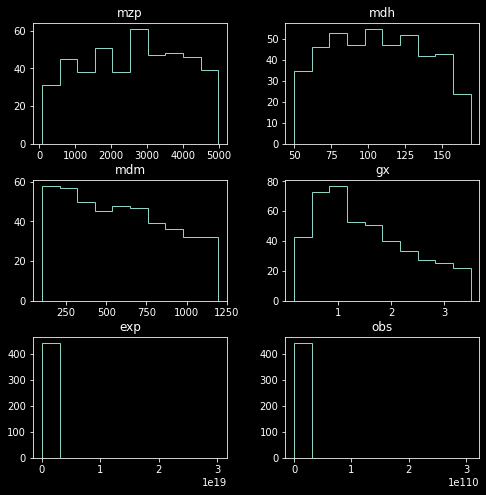

In [2]:
data = pd.read_csv("./data/truth_level_4D.csv")
data = data.drop(columns=['Unnamed: 0', 'gq']) #gq is constant
nan_rows = data[data.isna().any(axis=1)]
data.dropna(subset = ["obs", "exp"], inplace=True) #drop NaN obs, exp limits rows
data.hist(figsize=(8,8), histtype='step', grid=False);

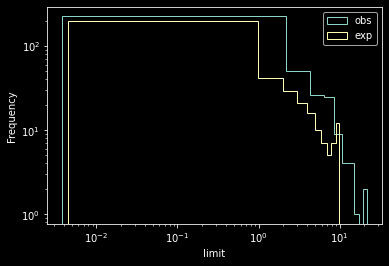

In [3]:
# exp and obs have values that are too large
clean_data = data.loc[data['exp']<10]
clean_data = clean_data.loc[data['obs']<100]
clean_data['obs'].plot.hist(logx=True, logy=True, histtype='step');
clean_data['exp'].plot.hist(logx=True, logy=True, histtype='step');
plt.legend();
plt.xlabel('limit');


In [4]:
parameters = ['mzp', 'mdh', 'mdm', 'gx'] 
targets = ['obs', 'exp']

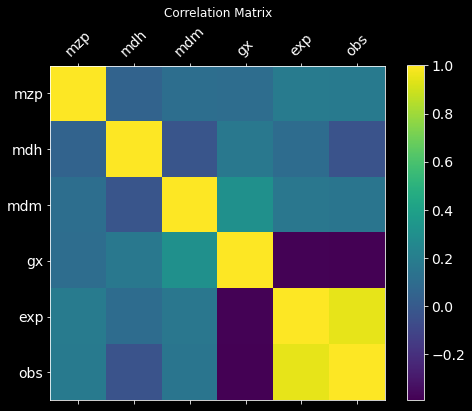

In [5]:
f = plt.figure(figsize=(8, 6))
plt.matshow(clean_data.corr(), fignum=f.number)
plt.xticks(range(clean_data.shape[1]), clean_data.columns, fontsize=14, rotation=45)
plt.yticks(range(clean_data.shape[1]), clean_data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix');


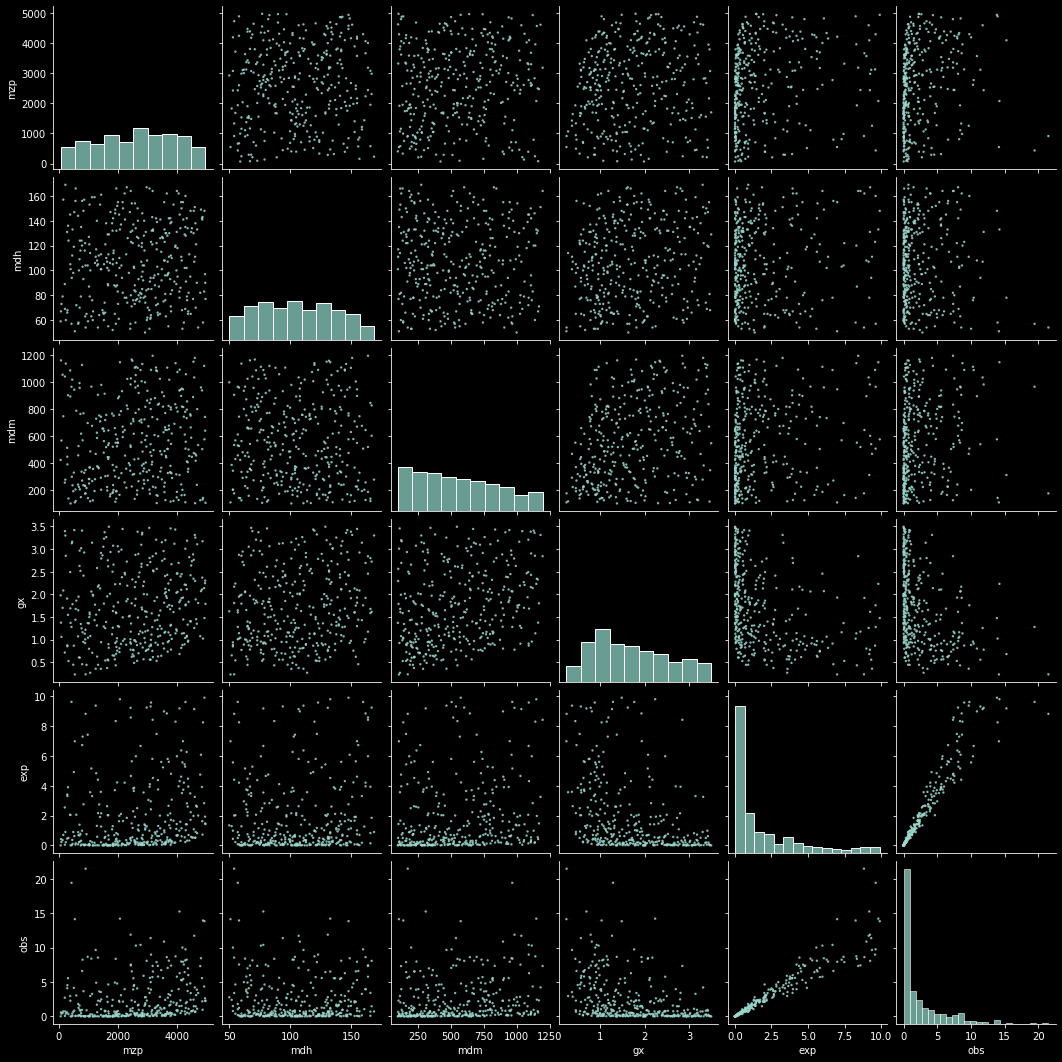

In [6]:
import seaborn as sns
g = sns.pairplot(clean_data, diag_kind="hist",  \
                plot_kws=dict(marker="o", s=5, alpha=0.9, linestyles=[":"]),\
                 height=2.5)

g.savefig("pairplot_raw_data.pdf")

In [7]:
# convert to tensor after exploration
param = torch.tensor(clean_data[parameters].values, dtype=torch.float32) 
obs = torch.tensor(clean_data['obs'].values, dtype=torch.float32)
exp = torch.tensor(clean_data['exp'].values, dtype=torch.float32)
print('param ', param.shape)
print('limit obs ', obs.shape) 
print('limit exp ', exp.shape) 

param  torch.Size([345, 4])
limit obs  torch.Size([345])
limit exp  torch.Size([345])


param_norm torch.Size([345, 4])
obs_norm torch.Size([345, 1])
exp_norm torch.Size([345, 1])


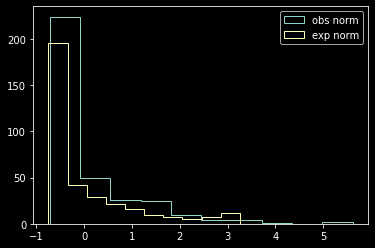

mean param_norm -5.528546953570412e-09
std param_norm 1.000362515449524
mean obs_norm -4.146409882110902e-09
std obs_norm 1.0014524459838867
mean exp_norm -5.528546953570412e-09
std exp_norm 1.0014524459838867


In [8]:
''' No data to spare
# split train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(param, limits[], test_size=0.1, random_state=42)
print('train: ', len(X_train))
print('test: ', len(X_test))
'''

#normalize all data
from sklearn.preprocessing import StandardScaler
scaler_param = StandardScaler()
#param
scaler_param.fit(param.detach().numpy())
param_norm = torch.Tensor(scaler_param.transform(param.detach().numpy()))
print('param_norm', param_norm.shape)
#obs
scaler_obs = StandardScaler()
scaler_obs.fit(obs.reshape(-1,1).numpy())
obs_norm = torch.Tensor(scaler_obs.transform(obs.reshape(-1,1).numpy()))
print('obs_norm', obs_norm.shape)
#exp
scaler_exp = StandardScaler()
scaler_exp.fit(exp.reshape(-1,1).numpy())
exp_norm = torch.Tensor(scaler_exp.transform(exp.reshape(-1,1).numpy()))
print('exp_norm', exp_norm.shape)

plt.hist(obs_norm.numpy(), histtype='step', label='obs norm');
plt.hist(exp_norm.numpy(), histtype='step', label='exp norm');
plt.legend();
plt.show()
print(f"mean param_norm {param_norm.mean()}")
print(f"std param_norm {param_norm.std()}")
print(f"mean obs_norm {obs_norm.mean()}")
print(f"std obs_norm {obs_norm.std()}")
print(f"mean exp_norm {exp_norm.mean()}")
print(f"std exp_norm {exp_norm.std()}")

Looks like normalization is healthy 

## Define GP model to use

In [11]:
import gpytorch

#class MultitaskGPModel(gpytorch.models.ExactGP):
#    def __init__(self, train_x, train_y, likelihood):
#        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
#        self.mean_module = gpytorch.means.MultitaskMean(
#            gpytorch.means.ConstantMean(), num_tasks=2
#        )
#        self.covar_module = gpytorch.kernels.MultitaskKernel(
#            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
#        )
#
#    def forward(self, x):
#        mean_x = self.mean_module(x)
#        covar_x = self.covar_module(x)
#        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Train the model

In [12]:
# initialize likelihood and model    
param_norm = param_norm.to(device) 
exp_norm = exp_norm.to(device)

#likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood = likelihood.to(device)

model = ExactGPModel(param_norm, exp_norm, likelihood)
model = model.to(device)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
SAVE_PATH = './bestmodel_4Dtruth_exp.pth' #save 

training_iterations = 4000
best_loss = 1E10
losses = []
hyperparams = []

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(param_norm) 
    loss = -mll(output, exp_norm.view(-1)) # .contiguous() #avoid running into shape error
    loss.backward(retain_graph=True)
    losses.append(loss.item())
    hyperparams.append(model.parameters())
    if(i%500==0):
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    #save model
    if(loss < best_loss):
        best_loss = loss
        torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, SAVE_PATH)
    
    optimizer.step()

Iter 1/4000 - Loss: 1.246
Iter 501/4000 - Loss: 0.988
Iter 1001/4000 - Loss: 0.986
Iter 1501/4000 - Loss: 0.986
Iter 2001/4000 - Loss: 0.986
Iter 2501/4000 - Loss: 0.986
Iter 3001/4000 - Loss: 0.986
Iter 3501/4000 - Loss: 0.986


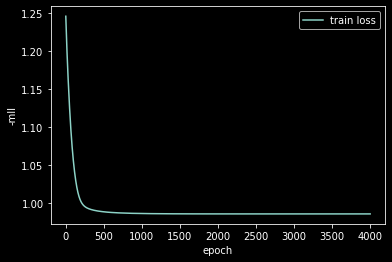

In [13]:
plt.plot(range(4000), losses, label='train loss')
plt.xlabel('epoch')
plt.ylabel('-mll')
plt.legend()

In [14]:
for i in hyperparams[0]:
    print(i)

Parameter containing:
tensor([-1.7312], requires_grad=True)
Parameter containing:
tensor([2.1221], requires_grad=True)
Parameter containing:
tensor(5.3625, requires_grad=True)
Parameter containing:
tensor([[1.1282]], requires_grad=True)


$$  k_{RBF}(X, X') = C \exp\left(-\frac{|| X-X' ||^2}{2l^2}\right) $$

In [28]:

print(f"lenghtscale l = {model.covar_module.base_kernel.lengthscale.item()}")
print(f"outputscale C =  {model.covar_module.outputscale.item()}")

lenghtscale l = 1.4085501432418823
outputscale C =  5.367133617401123


In [31]:
for i in model.named_parameters():
    print(i)

('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-1.7312], requires_grad=True))
('mean_module.constant', Parameter containing:
tensor([2.1221], requires_grad=True))
('covar_module.raw_outputscale', Parameter containing:
tensor(5.3625, requires_grad=True))
('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[1.1282]], requires_grad=True))


# Evaluate posterior mean

In [40]:
#MAKE MESHGRID COUNTOURF    
import numpy as np
mzp = np.arange(501., 5000., 500)
mdm = np.arange(101., 1200., 100)
mdh = np.arange(51., 170., 10)
g = np.arange(0.1, 3.5, 0.5)

#plot meshgrid
#MZP, MDM, MDH, G = np.meshgrid(mzp, mdm, mdh, g)

#test = torch.Tensor(np.transpose([np.tile(mzp, len(mdm)), np.repeat(mdm, len(mzp))])    )
#test[:, 0] = (test[:,0] - scaler_param.mean_[0])/scaler_param.scale_[0]
#test[:, 0] = (test[:,0] - scaler_param.mean_[0])/scaler_param.scale_[0]

likelihood.eval();
model.eval();

#with torch.no_grad(), gpytorch.settings.fast_pred_var():
#    prediction_grid = model(norm_test)
#    prediction_mean_grid = prediction_grid.mean
    

In [ ]:
inverse_x_test = scaler.inverse_transform(X_test)
inverse_x_train = scaler.inverse_transform(X_train)
im = plt.contourf(X, Y, f_mean_grid.view(len(y), len(x)).cpu().numpy(), 50, alpha=1)
line  = plt.contour(X, Y,f_mean_grid.view(len(y), len(x)).cpu().numpy(),levels = [1.0], colors=('white'),linestyles=('-',),linewidths=(2,), label='predicted')
plt.clabel(line, fmt = '$\mu$ = %2.1d', colors = 'white', fontsize=8, inline=True) #contour line labels
plt.scatter(inverse_x_test[:,0], inverse_x_test[:,1], color='white', s=25, alpha=0.3, marker='*', label='test points')
plt.scatter(inverse_x_train[:,0], inverse_x_train[:,1], color='black', s=20,alpha=0.3, marker='*', label='train points')

cbar = plt.colorbar(im)
cbar.set_label('sensitivity',size=8)
plt.xlabel('$m_{Z\prime}$ [GeV]')
plt.ylabel('$m_s$ [GeV]')
plt.legend(bbox_to_anchor=(1.3,1), loc="upper left", facecolor='lightgrey')
plt.title('GP mean conditioned on truth level data')
plt.savefig('./mean_with_test_obs.pdf')

# Active Learning

In [ ]:
%pylab inline
%load_ext autoreload
%autoreload 2

In [ ]:
np.warnings.filterwarnings('ignore')
import excursion